# Using Google Directions API for speed calculation

You can generate and send google directions API requests based on the network. The process will create a 'car' modal
subgraph and generate API requests for all edges in the subgraph. The number of requests is at most the number of edges
in the subgraph. The process simplifies edges using `osmnx` library's method to extract a chains of nodes with no
intersections, in this way reducing the number of requests. If your graph is already simplified, the number of requests
will be equal to the number of edges.

In [1]:
import genet
from genet import read_matsim, google_directions
from genet.utils.persistence import ensure_dir
from genet.outputs_handler.geojson import generate_geodataframes

import numpy as np
import geopandas as gpd
import json
import pandas as pd
import ast
import os
import itertools
import logging
import osmnx as ox
import polyline
import matplotlib.pyplot as plt
from shapely.geometry import LineString

/Applications/anaconda3/envs/genet/lib/python3.7/site-packages/geopandas/_compat.py:110: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.10.0-CAPI-1.16.0). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


## 1. Creating requests

First of all, we need to read in the network for which the requests are being generated

In [2]:
path_to_matsim_network = '../example_data/pt2matsim_network'

network = os.path.join(path_to_matsim_network, 'network.xml')
schedule = os.path.join(path_to_matsim_network, 'schedule.xml')
vehicles = os.path.join(path_to_matsim_network, 'vehicles.xml')

network_epsg = 'epsg:27700'

n = read_matsim(
    path_to_network=network, 
    epsg=network_epsg, 
    path_to_schedule=schedule, 
    path_to_vehicles=vehicles
)

# you don't need to read the vehicles file, but doing so ensures all vehicles in the schedule 
# are of the expected type and the definition of the vehicle is preserved
n.print()

Graph info: Name: Network graph
Type: MultiDiGraph
Number of nodes: 1662
Number of edges: 3166
Average in degree:   1.9049
Average out degree:   1.9049 
Schedule info: Schedule:
Number of services: 9
Number of routes: 68
Number of stops: 45


Next we define the function to generate requests; it takes as input the network and the list of osm tags

In [3]:
# osm_tags = takes a list of osm tags to filter the network on, e.g. ['primary', 'secondary', 'tertiary']

def generate_requests(n, osm_tags):
    subgraph = n.subgraph_on_link_conditions(
            conditions = [
                {'attributes': {'osm:way:highway': {'text': osm_tags}}},
                {'modes' : 'car'}],
            how = all, 
            mixed_dtypes = True)

    simple_paths = list(ox.simplification._get_paths_to_simplify(subgraph))
    node_diff = set(subgraph.nodes) - set(itertools.chain.from_iterable(simple_paths))
    non_simplified_edges = set(subgraph.out_edges(node_diff)) | set(subgraph.in_edges(node_diff))
    all_paths = list(non_simplified_edges) + simple_paths

    api_requests = {}

    for path in all_paths:
        request_nodes = (path[0], path[-1])
        api_requests[request_nodes] = {
            'path_nodes': path,
            'path_polyline': polyline.encode([(n.node(node)['lat'], n.node(node)['lon']) for node in path]),
            'origin': n.node(request_nodes[0]),
            'destination': n.node(request_nodes[1])}

    return api_requests

Let's create requests to get speed information for the main roads, print the number of requests, and save requests in a json file.

In [4]:
tag = ['secondary']
requests = generate_requests(n, tag)
print(len(requests))

genet.utils.google_directions.dump_all_api_requests_to_json(requests, '../example_data/', 'api_requests_send.json')

2021-11-23 13:58:06,524 - Saving Google Directions API requests to ../example_data/


52


136 requests were generated. The number of requests to be sent is important as it will influence the cost of Google Directions API. Current pricing can be found here: https://developers.google.com/maps/documentation/directions/usage-and-billing

It can be useful to visualise the requests before sending them, to confirm that they are as expected. Section 5 explains how to visualise requests you generate and results you receive from the API using Kepler. 

## 2. Sending requests

### 2.1 Sending requests created in Section 1

To send requests to Google Direction API you need a key [(read more here)](https://developers.google.com/maps/documentation/directions/start). After obtaining a key, you can either pass it to the elevant function directly

In [5]:
# Specify your own key
api_key = 'YOUR API KEY'

In [6]:
# Read in the API requests generated in the previous section
path = '../example_data/api_requests_send.json'
api_requests = genet.utils.google_directions.read_api_requests(path)

Before we send the requests, we need to specify the time of departure:
- `None` to get duration based on road network and average time-independent traffic conditions
- `now` for current time
- Time in the future as an integer in seconds since midnight, January 1, 1970 UTC, i.e. unix time (this website is useful for converting to unix time https://www.epochconverter.com )

More details about `departure_time` parameter can be found here: https://developers.google.com/maps/documentation/directions/get-directions#departure_time

If you set `departure_time` parameter to `now` or a time in the future, you can also specify the `traffic_model` parameter:
- `best_guess` (default): indicates that the returned duration_in_traffic should be the best estimate of travel time given what is known about both historical traffic conditions and live traffic. Live traffic becomes more important the closer the departure_time is to now.
- `pessimistic`: indicates that the returned duration_in_traffic should be longer than the actual travel time on most days, though occasional days with particularly bad traffic conditions may exceed this value.
- `optimistic`: indicates that the returned duration_in_traffic should be shorter than the actual travel time on most days, though occasional days with particularly good traffic conditions may be faster than this value.

More details about `traffic_model` parameter can be found here: https://developers.google.com/maps/documentation/directions/get-directions#traffic_model

In [7]:
# You may want to set a limit on the number of requests you are happy to send, to avoid excess costs if there is a mistake
lim = 55

if len(api_requests) < lim:
    output_dir = '../example_data/example_google_speed_data/'
    filename = 'api_requests_received.json'

    logging.info('Sending API requests')
    api_requests = genet.google_directions.send_requests(api_requests=api_requests,
                                                         departure_time=1665563400,
                                                         traffic_model='best_guess',
                                                         key=api_key)      

    logging.info('Parsing API requests')
    api_requests = genet.google_directions.parse_results(api_requests=api_requests)

    logging.info('Saving API requests')
    genet.google_directions.dump_all_api_requests_to_json(api_requests=api_requests, 
                                                          output_dir=output_dir, 
                                                          output_file_name=filename)

This method will save derived results in the output directory provided, an example can be found here: 
`../example_data/example_google_speed_data`. 

It comprises of the google polyline of the response and speed derived from distance and time taken to travel as well as information that was generated in order to make the response such as the node IDs in the network for which this response holds, the `path_nodes` which denote any extra nodes from the non-simplified chain of nodes/edges in the request, the polyline of the network path, encoded using the same polyline encoding as the Google request polyline; as well as spatial information about the origin and destination of the request and timestamp.

### 2.2 Generating and sending requests in one step

The steps described above give you flexibility in choosing the parts of the network for which you want to send the requests. If you are happy to send the requests for the whole network, you can skip sections 1 and 2.1 and go straight to the steps below (you still need to load the network first).

If you know the API key, you can specify it in the function call:

Or set it as an environmental variable called `GOOGLE_DIR_API_KEY`, if using command line: `$ export GOOGLE_DIR_API_KEY='key'`

If you use AWS, you can also store the key in the `Secrets Manager` [(read more here)](https://aws.amazon.com/secrets-manager/)
authenticate to your AWS account and then pass the `secret_name` and `region_name` to the `send_requests_for_network` 
method:

## 3. Processing the requests

### 3.1 Attaching the speed values from requests to the network

Once the request results have been received, you can read them in from the output directory you specified. 

In [8]:
api_requests = google_directions.read_api_requests('../example_data/example_google_speed_data/api_requests_received.json')

In [9]:
api_requests

{('821550', '821559'): {'path_nodes': ('821550', '821559'),
  'path_polyline': 'icnyH|c[jDmA',
  'origin': {'id': '821550',
   'x': 528849.3511895654,
   'y': 182113.8126146983,
   'lon': -0.1441511870930946,
   'lat': 51.523250333239496,
   's2_id': 5221390328818504945},
  'destination': {'id': '821559',
   'x': 528878.7128509199,
   'y': 182019.1831767487,
   'lon': -0.1437627870934339,
   'lat': 51.52239323323963,
   's2_id': 5221390325857124155},
  'timestamp': 1637671582.6685598,
  'request_payload': {'geocoded_waypoints': [{'geocoder_status': 'OK',
     'place_id': 'ChIJN_p-Eg4bdkgRbsBfrsnuoKs',
     'types': ['establishment', 'point_of_interest']},
    {'geocoder_status': 'OK',
     'place_id': 'ChIJJ9VtzU0bdkgRWS85N0hsEFU',
     'types': ['establishment', 'point_of_interest']}],
   'routes': [{'bounds': {'northeast': {'lat': 51.523248, 'lng': -0.14374},
      'southwest': {'lat': 51.5223974, 'lng': -0.1441294}},
     'copyrights': 'Map data ©2021',
     'legs': [{'distance': {'

Once you have results, you can attach them to the network. This will create a dictionary of non-simplified edges to which the response data applies.

In [10]:
google_edge_data = google_directions.map_results_to_edges(api_requests)

In [11]:
google_edge_data

{('821550', '821559'): {'google_speed': 4.260869565217392,
  'google_polyline': 'icnyHxc[|Bw@j@U'},
 ('109349', '60035533'): {'google_speed': 4.0,
  'google_polyline': 'ifnyHf{VEB'},
 ('107848', '14791189'): {'google_speed': 2.0416666666666665,
  'google_polyline': 'whmyH`sXn@lBDC'},
 ('14791189', '107848'): {'google_speed': 2.7222222222222223,
  'google_polyline': 'agmyHjvXEBo@mB'},
 ('60035532', '60035533'): {'google_speed': 4.25,
  'google_polyline': '}enyH~{VE[EBEB'},
 ('60035532', '60035535'): {'google_speed': 4.5,
  'google_polyline': '}enyH~{VE[JG'},
 ('2047806084', '255566'): {'google_speed': 8.0,
  'google_polyline': 'mrlyHdnZKF'},
 ('1667203491', '1684410054'): {'google_speed': 2.522727272727273,
  'google_polyline': 'ixlyH~`\\~DwA'},
 ('1684410054', '1684410058'): {'google_speed': 3.0,
  'google_polyline': 'irlyHf~[WwC'},
 ('25522558', '821550'): {'google_speed': 4.5,
  'google_polyline': '}dnyHlb[Rb@NJHADA'},
 ('60035535', '3943984251'): {'google_speed': 4.222222222222222,


In [12]:
n.edge('9791490', '4698712638')

{0: {'id': '596',
  'from': '9791490',
  'to': '4698712638',
  'freespeed': 4.166666666666667,
  'capacity': 600.0,
  'permlanes': 1.0,
  'oneway': '1',
  'modes': {'car'},
  's2_from': 5221390682074967269,
  's2_to': 5221390682013665025,
  'attributes': {'osm:way:access': {'name': 'osm:way:access',
    'class': 'java.lang.String',
    'text': 'no'},
   'osm:way:highway': {'name': 'osm:way:highway',
    'class': 'java.lang.String',
    'text': 'unclassified'},
   'osm:way:id': {'name': 'osm:way:id',
    'class': 'java.lang.Long',
    'text': '476247613'},
   'osm:way:name': {'name': 'osm:way:name',
    'class': 'java.lang.String',
    'text': 'Chitty Street'}},
  'length': 33.76444553419279}}

If we're working with a network that may have multiple edges between the same pair of nodes, we can restrict the links to which the data will be applied by specifying a modal condition, so that at least only links allowing cars will inherit this data.

In [13]:
def modal_condition(value):
    return 'car' in value

In [14]:
n.apply_attributes_to_edges(google_edge_data, conditions={'modes': modal_condition})

2021-11-23 13:58:06,824 - Changed Edge attributes for 180 edges


This will result in two new data points in the relevant links: `google_speed` and `google_polyline`.

In [15]:
n.edge('9791490', '4698712638')

{0: {'id': '596',
  'from': '9791490',
  'to': '4698712638',
  'freespeed': 4.166666666666667,
  'capacity': 600.0,
  'permlanes': 1.0,
  'oneway': '1',
  'modes': {'car'},
  's2_from': 5221390682074967269,
  's2_to': 5221390682013665025,
  'attributes': {'osm:way:access': {'name': 'osm:way:access',
    'class': 'java.lang.String',
    'text': 'no'},
   'osm:way:highway': {'name': 'osm:way:highway',
    'class': 'java.lang.String',
    'text': 'unclassified'},
   'osm:way:id': {'name': 'osm:way:id',
    'class': 'java.lang.Long',
    'text': '476247613'},
   'osm:way:name': {'name': 'osm:way:name',
    'class': 'java.lang.String',
    'text': 'Chitty Street'}},
  'length': 33.76444553419279}}

Next, we can validate the difference between `freespeed` and `google_speed`.

In [16]:
def speed_difference(link_attribs):
    return link_attribs['freespeed'] - link_attribs['google_speed']

In [17]:
n.apply_function_to_links(speed_difference, 'speed_difference')

2021-11-23 13:58:06,859 - 2986 out of 3166 links have not been affected by the function. Links affected: ['1020', '1065', '1066', '1078', '1086', '1087', '1088', '1089', '1090', '1091', '1092', '1123', '1175', '1176', '1178', '1184', '1185', '1186', '1199', '1200', '1201', '1202', '1238', '1240', '1244', '1251', '1252', '1253', '1254', '1256', '1257', '1258', '1259', '1289', '1290', '1317', '1318', '1319', '1320', '146', '147', '1474', '1476', '1477', '1530', '1531', '1532', '1533', '1534', '1535', '1536', '1537', '1638', '1641', '1645', '1646', '1647', '1648', '1649', '1650', '1651', '1652', '1653', '1654', '1655', '1656', '1736', '1760', '1761', '1799', '18', '1800', '1891', '1892', '19', '191', '1917', '1918', '192', '1953', '1954', '1955', '1973', '1992', '2041', '2042', '2043', '2044', '2053', '2054', '2119', '2171', '2178', '2179', '2180', '2181', '2182', '2183', '2184', '2185', '2225', '2247', '2248', '2249', '2275', '2348', '2361', '2362', '2369', '2370', '2371', '2373', '2378'

You can also choose to set google speed as the `freespeed` in the network. But be mindful if you use it for MATSim
simulations, `freespeed` denotes the maximum speed a vehicle can travel on a certain link, Google Directions API data
with `departure_time='now'` should be ran late at night/early morning ~4am local time to the network for any reliable results.
Otherwise you are adding traffic conditions to the network which should be simulated by demand (population) side of 
the model rather than supply (network).

In [18]:
def set_google_speed(link_attribs):
    if link_attribs['google_speed'] != 0:
        return link_attribs['google_speed']
    else:
        return link_attribs['freespeed']

In [19]:
n.apply_function_to_links(set_google_speed, 'freespeed')

2021-11-23 13:58:06,929 - 2986 out of 3166 links have not been affected by the function. Links affected: ['1020', '1065', '1066', '1078', '1086', '1087', '1088', '1089', '1090', '1091', '1092', '1123', '1175', '1176', '1178', '1184', '1185', '1186', '1199', '1200', '1201', '1202', '1238', '1240', '1244', '1251', '1252', '1253', '1254', '1256', '1257', '1258', '1259', '1289', '1290', '1317', '1318', '1319', '1320', '146', '147', '1474', '1476', '1477', '1530', '1531', '1532', '1533', '1534', '1535', '1536', '1537', '1638', '1641', '1645', '1646', '1647', '1648', '1649', '1650', '1651', '1652', '1653', '1654', '1655', '1656', '1736', '1760', '1761', '1799', '18', '1800', '1891', '1892', '19', '191', '1917', '1918', '192', '1953', '1954', '1955', '1973', '1992', '2041', '2042', '2043', '2044', '2053', '2054', '2119', '2171', '2178', '2179', '2180', '2181', '2182', '2183', '2184', '2185', '2225', '2247', '2248', '2249', '2275', '2348', '2361', '2362', '2369', '2370', '2371', '2373', '2378'

In [20]:
n.edge('9791490', '4698712638')

{0: {'id': '596',
  'from': '9791490',
  'to': '4698712638',
  'freespeed': 4.166666666666667,
  'capacity': 600.0,
  'permlanes': 1.0,
  'oneway': '1',
  'modes': {'car'},
  's2_from': 5221390682074967269,
  's2_to': 5221390682013665025,
  'attributes': {'osm:way:access': {'name': 'osm:way:access',
    'class': 'java.lang.String',
    'text': 'no'},
   'osm:way:highway': {'name': 'osm:way:highway',
    'class': 'java.lang.String',
    'text': 'unclassified'},
   'osm:way:id': {'name': 'osm:way:id',
    'class': 'java.lang.Long',
    'text': '476247613'},
   'osm:way:name': {'name': 'osm:way:name',
    'class': 'java.lang.String',
    'text': 'Chitty Street'}},
  'length': 33.76444553419279}}

### 3.2 Validating google speed values

Once you have attached the google speed values to the network, you may want to do some validation, to check if the values make sense and if there are any missing values. 

To do that, we first need to convert the network to a geodataframe.

In [21]:
# If you only sent the requests for parts of the network with a certain OSM tag, 
# you should pass the list of those tags to the function graph_to_gdf()

def graph_to_gdf(network, osm_tag=all):
    subgraph_t = network.subgraph_on_link_conditions(
        conditions = [
            {'attributes': {'osm:way:highway': {'text': osm_tag}}},
            {'modes' : 'car'}],
        how = all, 
        mixed_dtypes = True)
    
    # convert subgraph to geodataframe
    gdf_dict = generate_geodataframes(subgraph_t)
    gdf = gdf_dict['links']
    
    # fill in missing points (due to network structure when filtering by osm_tag)  
    gdf.loc[gdf['geometry'].isna(), 'geometry'] = gdf.loc[gdf['geometry'].isna()].apply(
        lambda x: line_geometry(x['from'], x['to']), axis=1)
    
    # convert to epsg:4326 to allow visualisation in Kepler in section 4
    gdf = gdf.to_crs("epsg:4326")
    
    return gdf


# For filling in missing points
def line_geometry(u, v):
    from_node = n.node(u)
    to_node = n.node(v)
    return LineString(
        [(float(from_node['x']), float(from_node['y'])), (float(to_node['x']), float(to_node['y']))])

In [22]:
gdf = graph_to_gdf(n)
with_gs = gdf[gdf['google_speed'].notna()]
google_speed_list = with_gs['google_speed'].to_list()

In [24]:
minimum = min(google_speed_list)
maximum = max(google_speed_list)
zeros = sum(i <= 0 for i in google_speed_list)
average = sum(google_speed_list)/len(google_speed_list)

summary = ("Average value of google_speed is " + str(average) + " meters/seconds (=" + str(average*3.6) + " km/hour), "
"maximum value of google_speed is " + str(maximum) + " m/s (=" + str(maximum*3.6) + " km/h), minimum value of google_speed is " + str(minimum) 
+ " m/s (=" + str(minimum*3.6) + " km/h); there are " + str(zeros) + " links with google_speed value equal to 0 m/s")

logging.info(summary)

2021-11-23 13:58:08,519 - Average value of google_speed is 3.815765080269415 meters/seconds (=13.736754288969895 km/hour), maximum value of google_speed is 8.0 m/s (=28.8 km/h), minimum value of google_speed is 2.0416666666666665 m/s (=7.35 km/h); there are 0 links with google_speed value equal to 0 m/s


## 4. Visualising google speeds

There various tools available to visualise a genet network, and these are described in detail in the notebook `7. Visualising Network`. Here, we will have a quick look at how to visualise the google speeds in particular.

First, we can do a quick visualisation using GeoPandas tools themselves, by plotting the parts of the network which have a `google_speed` value.

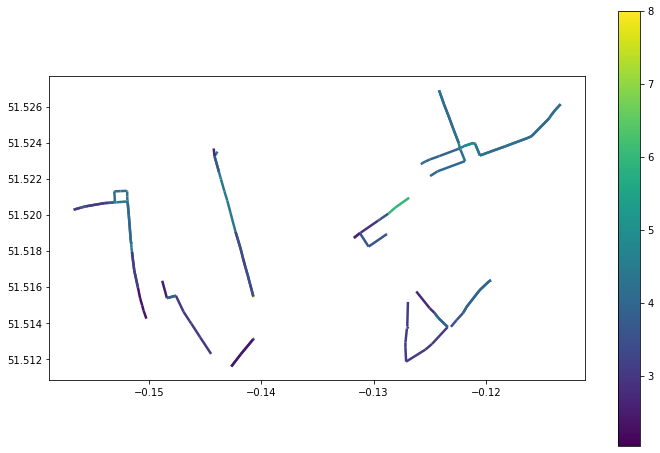

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(12,8))
gdf.plot(column='google_speed', ax=ax, legend=True, linewidth=2.5)

Since the visualisation above is quite simplistic, you may want to use Kepler instead. To do so, you just need to save the geodataframe in geojson format, and upload the file to Kepler: https://kepler.gl/demo

In [26]:
logging.info('saving network links with valid google speed values to geojson')
genet.outputs_handler.geojson.save_geodataframe(with_gs, 
                                                'api_requests_viz', 
                                                '../example_data/example_google_speed_data/')

2021-11-23 13:58:08,800 - saving network links with valid google speed values to geojson


Once the geojson file is uploaded to Kepler, click on the button next to `Stroke Colour` field (shown by green arrow in the image below). Then, in the field `Stroke Color Based On` choose `google_speed` from the drop down menu. You can also click on the table icon in the top right corner to display the legend.

<img src="../example_data/example_google_speed_data/kepler_api_requests.png">

You can save this map in html format by clicking on the 'Share' button in the top left corner and selecting 'Export Map'.